<a href="https://colab.research.google.com/github/lahoffman/ml_tutorial/blob/main/nn_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Set up

## 0.1 Set up your Google Colab Notebook to run this tutorial.

You will need to complete the following steps before you run this tutorial:

1. Save a copy of this notebook in your drive 
  - File --> 'Save a copy in Drive'
2. Download the data from github: 
  - Go to the github link for this tutorial (https://github.com/lahoffman/ml_tutorial). 
  - Navigate to the 'data/' folder and click on 'ALL_ITP_DATA.mat'
  - Click the 'Download' button on the right to download the data to your local machine (i.e. your computer)
3. Make a 'data' folder in your 'Colab Notebooks' folder in your google drive
  - On the left-hand toolbar for this page (i.e. your copy of the 'nn_regression.ipynb' notebook), click on the 'folder' icon.
  - Navigate to the folder for your Colab notebooks"
    - under 'MyDrive' Click on the small dropdown arrow next to 'content' -->  'drive' --> 'MyDrive' --> 'Colab Notebooks'.
  - Make a 'data' folder in your 'Colab Notebooks' folder
    - click the three dots to the right of "Colab Notebooks"
    - click 'New folder'; name the folder 'data'
4. Upload the dataset to your 'data' folder
  - click the three dots to the right of the 'data' folder
  - click 'upload'
  - find the 'ALL_ITP_DATA.mat' file you had downloaded to your comptuer
  - click 'upload'.
5. You are ready to run this notebook!

## 0.2 Set up Coding Environments

In [11]:
#system
import sys
import numpy as np
import seaborn as sb
import xarray as xr
import h5py

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
!pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1"
from mpl_toolkits.basemap import Basemap
!pip install cmocean
import cmocean
from scipy import stats, odr

#machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
import keras.utils
import sklearn
from sklearn.model_selection import train_test_split
from scipy import stats, odr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")  

python version = 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
numpy version = 1.22.4
tensorflow version = 2.11.0


# 1. Data Preparation

##1.1 About the Data

In this module we will train a machine learning model to make one-day predictions of ice velocity from information about present-day wind velocity (JRA55), previous-day ice concentration (Nimbus-7 Passive Microwave), and previous-day ice velocity (Ice-Tethered Profiler (ITP)). This analysis uses the ITP dataset as a baseline, thus the gridded products for wind and ice concentration are co-located in space and time with the ITPs. Descriptions of the datasets are provided below.

###1.1.1 Ice-Tethered Profilers: Ice Veolcity Vectors

We will be using the Ice-Tethered Profiler (ITP) dataset from WHOI. While the ITPs measure many quantities, we will be using ice velocity derived from the measured geographic locations of the ITPs.

The following images, captions, and data were collected and made available by the Ice-Tethered Profiler Program (Toole et al., 2011; Krishfield et al., 2008) based at the Woods Hole Oceanographic Institution (https://www.whoi.edu/itp).


<img src='https://www2.whoi.edu/site/itp/wp-content/uploads/sites/92/2019/08/itp_mooring.jpg' width = '200' height = '300'> 

*The ITP system consists of a small surface capsule that sits atop an ice flow and supports a plastic-jacketed wire rope tether that extends through the ice and down into the ocean, ending with a weight (intended to keep the wire vertical). A cylindrical underwater instrument (in shape and size much like an Argo float) mounts on this tether and cycles vertically along it, carrying oceanographic sensors through the water column.  Water property data are telemetered from the ITP to shore in near-real time.*

<img src = 'https://www.whoi.edu/itp/images/itpall.jpg?_gl=1*50odkx*_ga*NjU0NzIwMTI4LjE2NzgxMjI5NDY.*_ga_HLKFZX9JZK*MTY3ODEyMjk0Ni4xLjEuMTY3ODEyMzM4My4wLjAuMA..' width = '400' height = '300'> 

*Latest locations of all active ITPs. Systems that are presently providing location and profile data are in yellow, those that are providing locations only (profiler status uncertain) are in cyan, and those that have not transmitted data for over one month are plotted in gray. Also shown are annual ice drift vectors from IABP on IBCAO bathymetry.*

TOOLE, JOHN M., et al. “THE ICE-TETHERED PROFILER: ARGO OF THE ARCTIC.” Oceanography, vol. 24, no. 3, 2011, pp. 126–35. JSTOR, http://www.jstor.org/stable/24861307.

Krishfield, R., Toole, J., Proshutinsky, A., & Timmermans, M. (2008). Automated Ice-Tethered Profilers for Seawater Observations under Pack Ice in All Seasons, Journal of Atmospheric and Oceanic Technology, 25(11), 2091-2105. 

###1.1.2 Nimbus-7 Passive Microwave: Ice Concentration

We use daily measurements of sea-ice concentrations (fraction of ocean area covered by sea ice in each grid cell) provided by the Nimbus-7 Passive Microwave. These data are made available by the NSIDC and can be accessed at \url{https://doi.org/10.5067/8GQ8LZQVL0VL}.

###1.1.3 Japanese 55-year Reanalysis (JRA55): Wind Velocity Vectors

Here we use the wind velocity vectors from the Japanese 55-year atmospheric reanalysis based surface dataset for driving ocean-sea ice models (JRA55-do). The JRA-555 dataset can be accessed at \url{http://search.diasjp.net/en/dataset/JRA55}.

## 1.1 Data Download

In [13]:
#allow access to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#import dataset
df = h5py.File('/content/drive/MyDrive/Colab Notebooks/data/ALL_ITP_DATA.mat','r')

In [15]:
#variables
ui = np.array(df['fullData'][0,:]) #u-ice velocity
vi = np.array(df['fullData'][1,:]) #v-ice velocity
ua = np.array(df['fullData'][2,:]) #u-wind
va = np.array(df['fullData'][3,:]) #v-wind
ci = np.array(df['fullData'][4,:]) #ice concentration
lonitp = np.array(df['fullData'][5,:]) #longitude
latitp = np.array(df['fullData'][6,:]) #latitude
doy = np.array(df['fullData'][7,:]) #day of year
itp = np.array(df['fullData'][8,:]) #itp number
icespeed = np.sqrt(np.square(ui) + np.square(vi))
windspeed = np.sqrt(np.square(ua) + np.square(va))

## 1.2 Data Visualization

Before we build the ML model we want to understand the data we are using. Here we look at (a) maps and (b) scatter plots of the various inputs to the model. Are there any relationships between inputs that stand out?

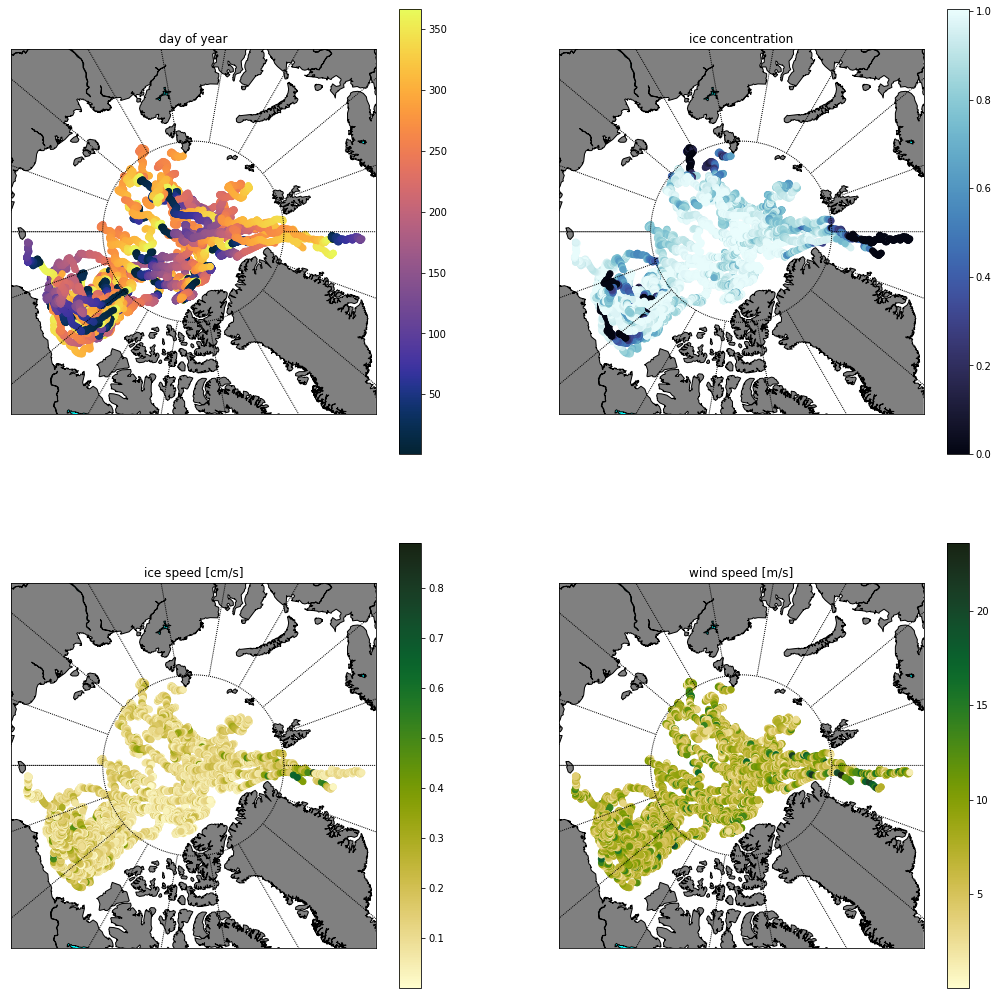

In [16]:
#(a) maps
#here we look at maps showing properties of interest at locations of the ITPs.
fig = plt.figure(figsize=(18,18))

#day of year
ax = fig.add_subplot(221)
ax.set_title('day of year')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp, latitp)
plt.scatter(x,y,c=doy,cmap=cmocean.cm.thermal)
plt.colorbar()

#ice concentration
ax = fig.add_subplot(222)
ax.set_title('ice concentration')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp, latitp)
plt.scatter(x,y,c=ci,cmap=cmocean.cm.ice)
plt.colorbar()

#ice speed
ax = fig.add_subplot(223)
ax.set_title('ice speed [cm/s]')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp, latitp)
plt.scatter(x,y,c=icespeed,cmap=cmocean.cm.speed)
plt.colorbar()

#wind speed
ax = fig.add_subplot(224)
ax.set_title('wind speed [m/s]')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp, latitp)
plt.scatter(x,y,c=windspeed,cmap=cmocean.cm.speed)
plt.colorbar()

plt.show()

Text(0, 0.5, 'ice concentration')

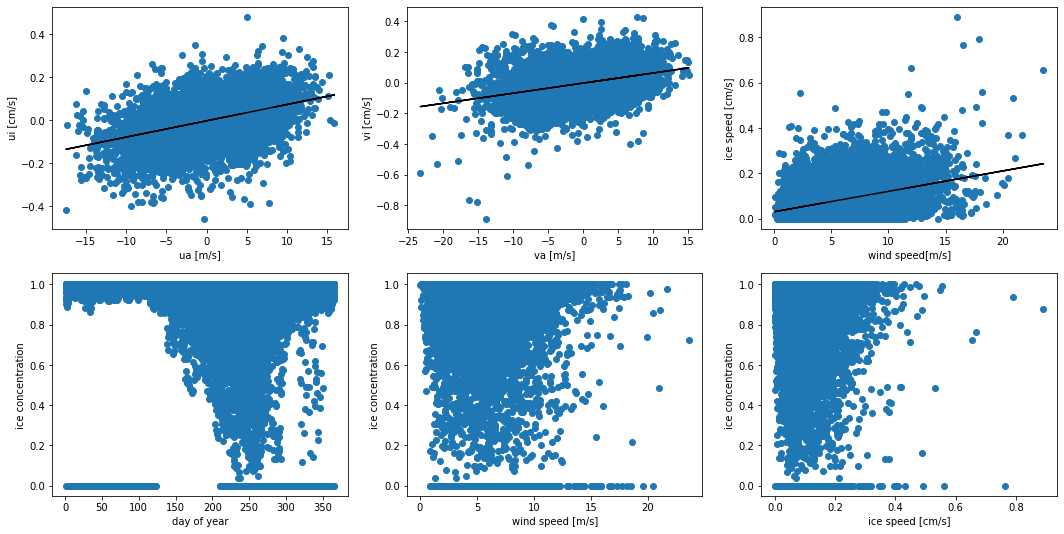

In [17]:
#(b) scatter: compare variables
#here we look at plots comparing some of the variables to get an idea of the relationships between them

fig, axs = plt.subplots(2, 3,figsize=(18,9))
axs[0,0].scatter(ua,ui)
axs[0,0].set_xlabel('ua [m/s]')
axs[0,0].set_ylabel('ui [cm/s]')
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(ua),np.squeeze(ui))
axs[0,0].plot(ua,intercept+ua*slope,'-',color = 'black', label = 'LSQ: x vs y')

axs[0,1].scatter(va,vi)
axs[0,1].set_xlabel('va [m/s]')
axs[0,1].set_ylabel('vi [cm/s]')
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(va),np.squeeze(vi))
axs[0,1].plot(va,intercept+va*slope,'-',color = 'black', label = 'LSQ: x vs y')

axs[0,2].scatter(windspeed,icespeed)
axs[0,2].set_xlabel('wind speed[m/s]')
axs[0,2].set_ylabel('ice speed [cm/s]')
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(windspeed),np.squeeze(icespeed))
axs[0,2].plot(windspeed,intercept+windspeed*slope,'-',color = 'black', label = 'LSQ: x vs y')

axs[1,0].scatter(doy,ci)
axs[1,0].set_xlabel('day of year')
axs[1,0].set_ylabel('ice concentration')

axs[1,1].scatter(windspeed,ci)
axs[1,1].set_xlabel('wind speed [m/s]')
axs[1,1].set_ylabel('ice concentration')

axs[1,2].scatter(icespeed,ci)
axs[1,2].set_xlabel('ice speed [cm/s]')
axs[1,2].set_ylabel('ice concentration')

## 1.3 Processing Data for ML

### 1.3.1 Feature Scaling

#### Why do we apply Feature Scaling?
Features (or variables) that are input to a ML model may have vastly different ranges, which might cause a ML model to put more weights on variables with a larger range. Feature Scaling (either standardization or normalization) makes it so features are on similar scales.

***Standardization:*** Here, data is standardized to zero mean and one standard deviation (i.e. subtract mean and divide by standard deviation).

In [18]:
#standardize data
uas = (ua-np.mean(ua))/np.std(ua)
vas = (va-np.mean(va))/np.std(va)
uis = (ui-np.mean(ui))/np.std(ui)
vis = (vi-np.mean(vi))/np.std(vi)
cis = (ci-np.mean(ci))/np.std(ci)
lats = (latitp-np.mean(latitp))/np.std(latitp)
lons = (lonitp-np.mean(lonitp))/np.std(lonitp)
doys = (doy-np.mean(doy))/np.std(doy)

### 1.3.2 Feature Exploration


In [19]:
#specify variables

n = 1
nn = n+1

#present-day [variables at day 0]
ui0 = uis[n:-1]
vi0 = vis[n:-1]
ua0 = uas[n:-1]
va0 = vas[n:-1]
ci0 = cis[n:-1]
lon0 = lons[n:-1]
lat0 = lats[n:-1]
doy0 = doys[n:-1]

#previous-day: vatiables at day 0-n
uin = uis[0:-nn]
vin = vis[0:-nn]
uan = uas[0:-nn]
van = vas[0:-nn]
cin = cis[0:-nn]
lonn = lons[0:-nn]
latn = lats[0:-nn]
doyn = doys[0:-nn]


print('uis:', uis.shape)
print('uio:', ui0.shape)
print('uin:', uin.shape)

uis: (17130,)
uio: (17128,)
uin: (17128,)


### 1.3.3 Create Input & Output Data

This is where you choose what you want as your inputs (predictors) and outputs (the thing you're predicting). Play around with using different variables in x & y and see how will your NN can make the desired predictions. 

Some ideas:

- Adding more days as inputs (i.e. previous n-days of wind or ice data)
- Removing predictors to look at the relative importance of each of them (i.e. how does the skill of the model change when we do not include information about the wind, etc.)

In [20]:
#concatenate desired inputs into x & y
x = np.stack((ua0,va0,uin,vin,cin,lat0,lon0),axis=1)

y = np.stack((ui0,vi0),axis=1)

### 1.3.4 Partitioning Data in Training, Validation, and Test Datasets

Data are split into train, validate, and test sets before entered into a ML model, typically with an 80% - 10% - 10% split.

***Train:***  Training data is used to fit the model.

***Validate:*** The validation dataset is used to evaluate the model fit during training and update the model hyperparameters.

***Test:*** The test dataset is not seen by the model during training and use used to provide an unbias evaluation of the final model fit.


In [21]:
#test set
xte = x[0:1713,:]
yte = y[0:1713,:]

#train and validate set
xt = x[1713:-1,:]
yt = y[1713:-1,:]

print('xt',xt.shape)
print('yt',yt.shape)

print('xte',xte.shape)
print('yte',yte.shape)

#split train and validate
x_train, x_val, y_train, y_val = train_test_split(xt,yt,test_size = .1, shuffle=True, random_state = 12)

xt (15414, 7)
yt (15414, 2)
xte (1713, 7)
yte (1713, 2)


# 2. Neural Network

## 2.1 Define Custom Metrics and Loss Functions

What is a loss function?

The cost / loss function evaluates the difference between the model prediction and the true data during training.


In [22]:
#define NRMSE function
def norm_root_mean_squared_error(y_true,y_pred):
    return  (K.sqrt(K.mean(K.square(y_pred - y_true))))/((K.std(y_true)))

#define pearson correlation 
def tf_pearson(y_true, y_pred):
    return (K.sum((y_true-K.mean(y_true))*(y_pred-K.mean(y_pred))))/((K.sqrt(K.sum(K.square(y_true-K.mean(y_true)))))*(K.sqrt(K.sum(K.square(y_pred-K.mean(y_pred))))))

## 2.2 Define Model Hyperparameters

In [23]:
# Here are some model hyperparameters we can edit


# LOSS FUNCTION
LOSS = norm_root_mean_squared_error # Loss Function used
METRIC = tf_pearson # Metric for assessing model skill

# MODEL TRAINING
NUM_EPOCHS = 20 # Max number of times all of the data will be seen iteratively in training
BATCH_SIZE = 365 # Number of samples
LEARNING_RATE = .1 # Learning rate (think step size)
DROP = 0.2



## 2.3 Building a Neural Network

### 2.3.1 The Linear Model

#### 2.3.1.1 Complie and train the model

Epoch 1/50
39/39 [==============================] - 1s 15ms/step - loss: 1.9692 - accuracy: 0.4211 - tf_pearson: -0.4203 - val_loss: 1.9610 - val_accuracy: 0.4300 - val_tf_pearson: -0.4040
Epoch 2/50
39/39 [==============================] - 0s 5ms/step - loss: 1.8805 - accuracy: 0.4278 - tf_pearson: -0.4031 - val_loss: 1.8692 - val_accuracy: 0.4377 - val_tf_pearson: -0.3914
Epoch 3/50
39/39 [==============================] - 0s 5ms/step - loss: 1.7937 - accuracy: 0.4345 - tf_pearson: -0.4234 - val_loss: 1.7792 - val_accuracy: 0.4429 - val_tf_pearson: -0.3757
Epoch 4/50
39/39 [==============================] - 0s 5ms/step - loss: 1.7057 - accuracy: 0.4403 - tf_pearson: -0.4092 - val_loss: 1.6936 - val_accuracy: 0.4514 - val_tf_pearson: -0.3582
Epoch 5/50
39/39 [==============================] - 0s 5ms/step - loss: 1.6278 - accuracy: 0.4467 - tf_pearson: -0.3621 - val_loss: 1.6138 - val_accuracy: 0.4585 - val_tf_pearson: -0.3364
Epoch 6/50
39/39 [==============================] - 0s 5ms/

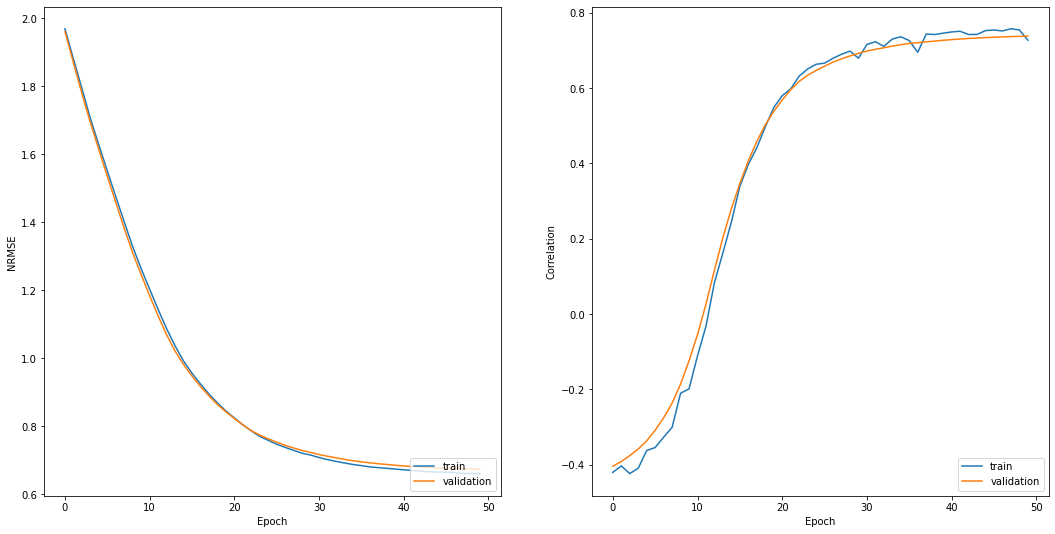

In [28]:
# Example: build a fully-connected network

# In Keras a NN model is built in layers
# Most common type is sequential layers - one layer after the other with 
# connections only between neighboring layers.

#hyperparameters
[nd,nc] = y_train.shape
NUM_EPOCHS = 50

# define the model: linear model with one layer
model = tf.keras.Sequential()
model.add(layers.Dense(nc,activation='linear'))

#compile and train model
model.compile(optimizer='adam',loss=LOSS ,metrics=['accuracy',METRIC])

# train the model
history = model.fit(x_train,y_train,epochs=NUM_EPOCHS,batch_size=BATCH_SIZE,shuffle=True,validation_data=(x_val,y_val))
print(history)
print(model.summary())

#evaluate model: plot the loss during training 
plot1 = plt.figure(1,figsize=(18,9))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['tf_pearson'],label='train')
plt.plot(history.history['val_tf_pearson'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.legend(loc='lower right')
plt.show()

#### 2.3.1.2 Evaluate and Visualize Model Predictions

54/54 [==============================] - 0s 1ms/step
ypred: (1713, 2)
ytrue: (1713, 2)


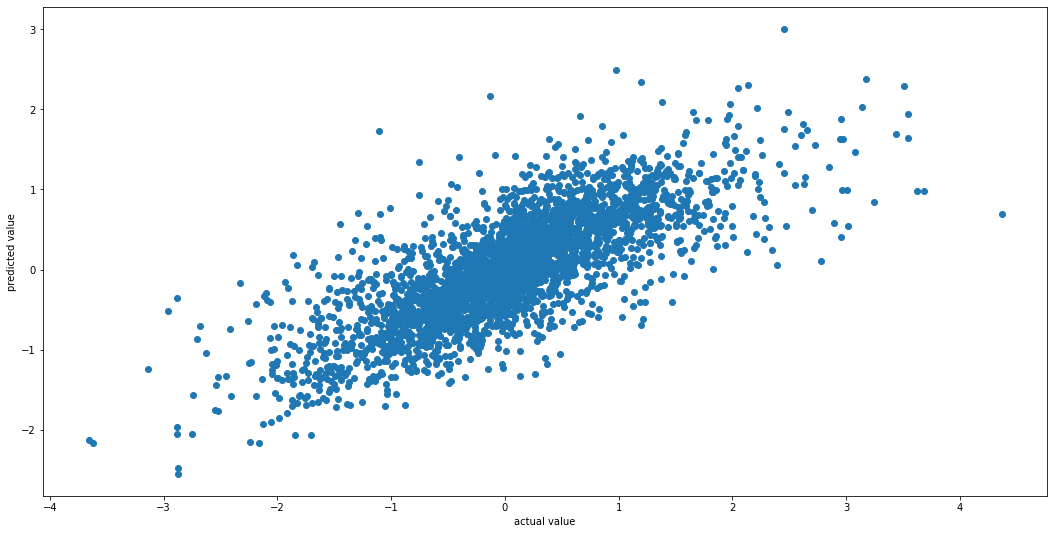

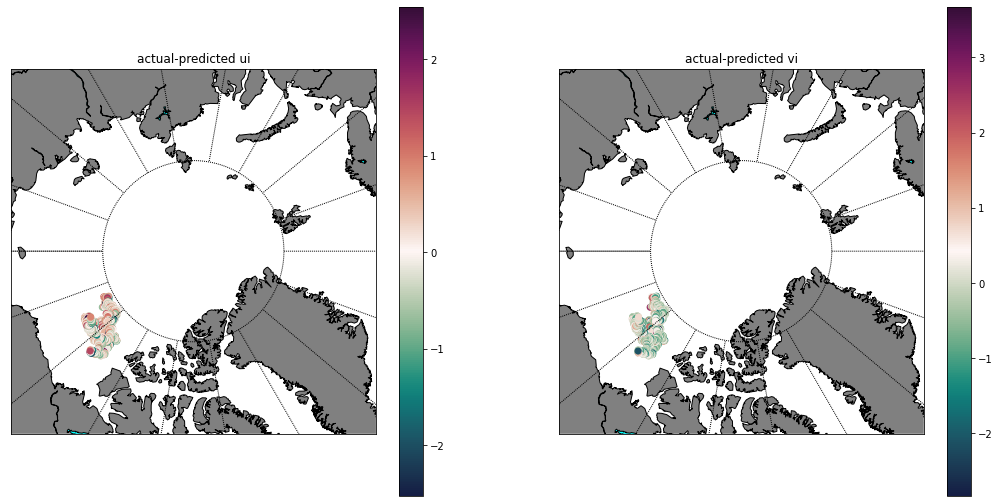

In [29]:
# make predictions with your model using the test dataset
y_true = yte
y_pred = model.predict(xte)

print('ypred:', y_pred.shape)
print('ytrue:', y_true.shape)

plt.figure(figsize=(18,9))
plt.scatter(y_true,y_pred)
plt.xlabel('actual value')
plt.ylabel('predicted value')

#difference betwen "actual" and "predicted" values of ui and vi
vdiff = y_true[:,1]-y_pred[:,1]
udiff = y_true[:,0]-y_pred[:,0]

#maps
fig = plt.figure(figsize=(18,9))

#actual-predicted for ui
ax = fig.add_subplot(121)
ax.set_title('actual-predicted ui')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp[0:1713], latitp[0:1713])
plt.scatter(x,y,c=udiff,cmap=cmocean.cm.curl)
plt.colorbar()


#actual-predicted for vi
ax = fig.add_subplot(122)
ax.set_title('actual-predicted vi')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp[0:1713], latitp[0:1713])
plt.scatter(x,y,c=vdiff,cmap=cmocean.cm.curl)
plt.colorbar()


### 2.3.2 Deep NN w/ hidden layers

####2.3.2.1 Compile and train the model

Epoch 1/50
39/39 [==============================] - 1s 10ms/step - loss: 0.9791 - accuracy: 0.6026 - tf_pearson: 0.2846 - val_loss: 0.9171 - val_accuracy: 0.6660 - val_tf_pearson: 0.4087
Epoch 2/50
39/39 [==============================] - 0s 4ms/step - loss: 0.8466 - accuracy: 0.6993 - tf_pearson: 0.5436 - val_loss: 0.8193 - val_accuracy: 0.7179 - val_tf_pearson: 0.5793
Epoch 3/50
39/39 [==============================] - 0s 4ms/step - loss: 0.7762 - accuracy: 0.7339 - tf_pearson: 0.6491 - val_loss: 0.7633 - val_accuracy: 0.7419 - val_tf_pearson: 0.6477
Epoch 4/50
39/39 [==============================] - 0s 4ms/step - loss: 0.7325 - accuracy: 0.7493 - tf_pearson: 0.6684 - val_loss: 0.7264 - val_accuracy: 0.7639 - val_tf_pearson: 0.6846
Epoch 5/50
39/39 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.7614 - tf_pearson: 0.6967 - val_loss: 0.7117 - val_accuracy: 0.7724 - val_tf_pearson: 0.6968
Epoch 6/50
39/39 [==============================] - 0s 4ms/step - los

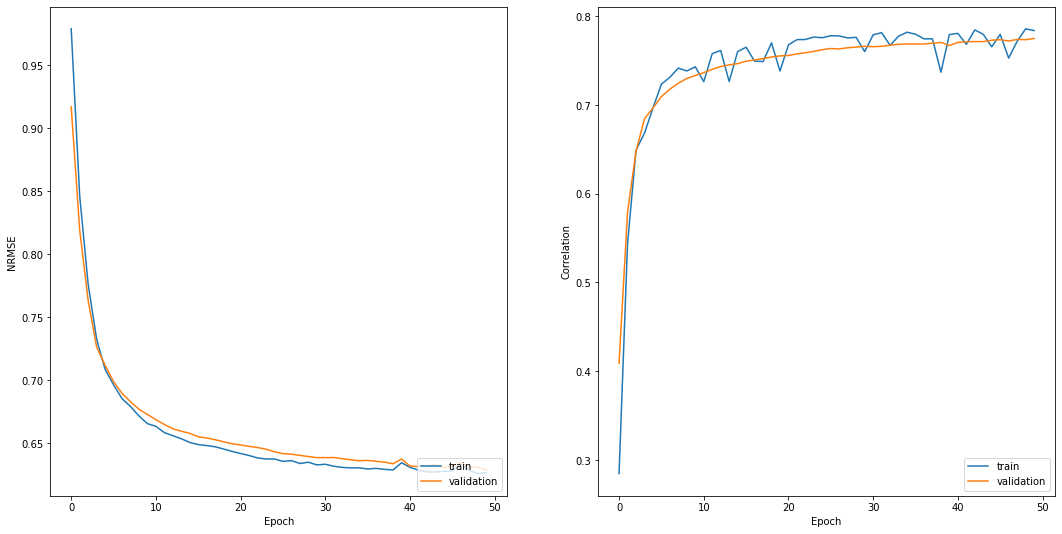

In [30]:
# Example: build a fully-connected network

# In Keras a NN model is built in layers
# Most common type is sequential layers - one layer after the other with 
# connections only between neighboring layers.

#
[nd,nc] = y_train.shape
n_units = 16

# define the model
model = tf.keras.Sequential()
model.add(layers.Dense(n_units,activation='relu'))
model.add(layers.Dense(n_units,activation='relu'))
model.add(layers.Dense(nc,activation=None))

#compile and train model
model.compile(optimizer='adam',loss=LOSS ,metrics=['accuracy',METRIC])

# train the model
history = model.fit(x_train,y_train,epochs=NUM_EPOCHS,batch_size=BATCH_SIZE,shuffle=True,validation_data=(x_val,y_val))
print(history)
print(model.summary())

#evaluate model: plot the loss during training 
plot1 = plt.figure(1,figsize=(18,9))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['tf_pearson'],label='train')
plt.plot(history.history['val_tf_pearson'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.legend(loc='lower right')
plt.show()


####2.3.2.2. Evaluate and Visualize Model Predictions

54/54 [==============================] - 0s 3ms/step
ypred: (1713, 2)
ytrue: (1713, 2)


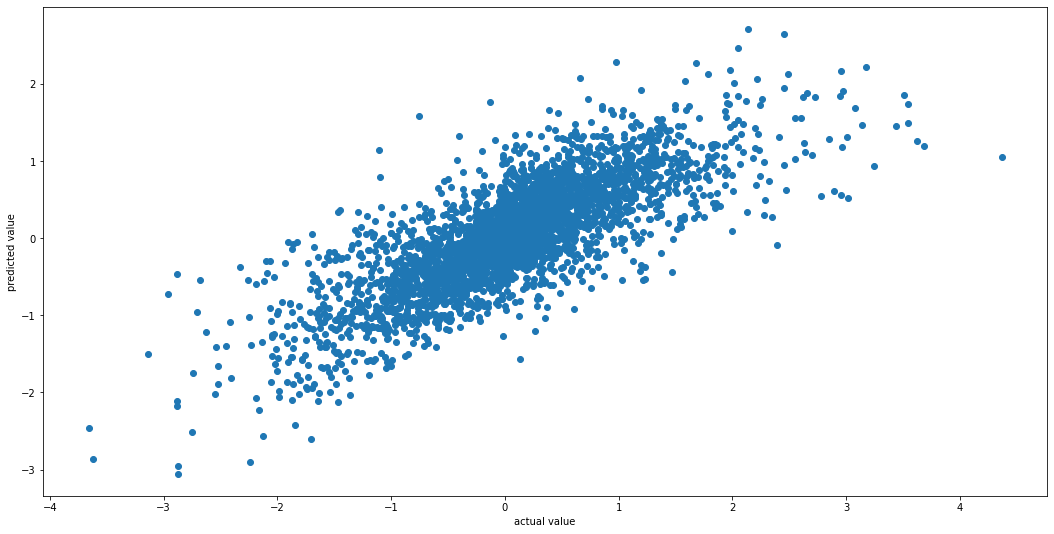

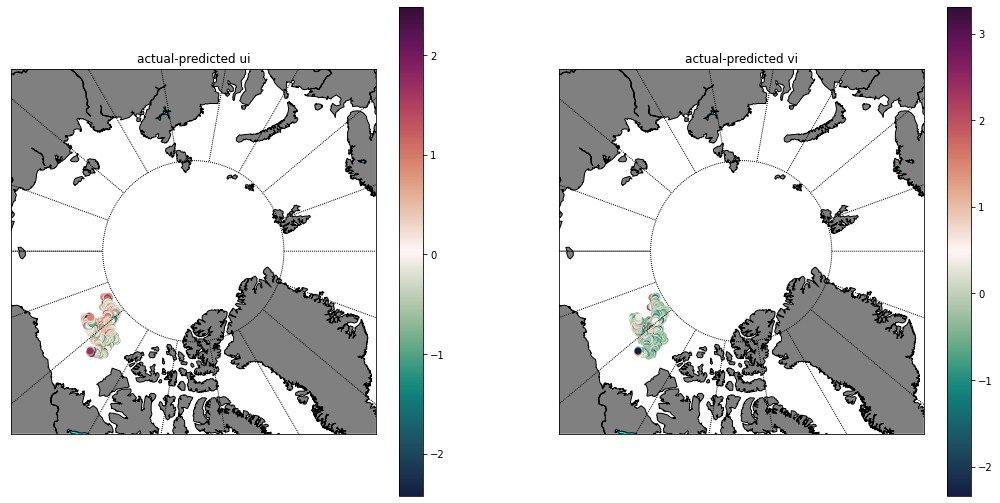

In [31]:
# make predictions with your model using the test dataset
y_true = yte
y_pred = model.predict(xte)

print('ypred:', y_pred.shape)
print('ytrue:', y_true.shape)

plt.figure(figsize=(18,9))
plt.scatter(y_true,y_pred)
plt.xlabel('actual value')
plt.ylabel('predicted value')

#difference betwen "actual" and "predicted" values of ui and vi
vdiff = y_true[:,1]-y_pred[:,1]
udiff = y_true[:,0]-y_pred[:,0]

#maps
fig = plt.figure(figsize=(18,9))

#actual-predicted for ui
ax = fig.add_subplot(121)
ax.set_title('actual-predicted ui')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp[0:1713], latitp[0:1713])
plt.scatter(x,y,c=udiff,cmap=cmocean.cm.curl)
plt.colorbar()


#actual-predicted for vi
ax = fig.add_subplot(122)
ax.set_title('actual-predicted vi')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp[0:1713], latitp[0:1713])
plt.scatter(x,y,c=vdiff,cmap=cmocean.cm.curl)
plt.colorbar()
